# Classification on Raisin Dataset Proposal

## Introduction

All aspects of the natural life around us are surrounded by patterns and relationships. Although some of these have been discovered, many natural phenomena are unexplainable as of today. Tools such as classification are used to further discern these natural patterns and make sense of our world by specifying and identifying different types or species of nature. Within this project, we will be aiming to show the importance of classification, by applying this concept to an example dataset regarding raisins. Within this dataset, 900 raisin grains were collected between two types of Turkish raisins, Kecimen and Besni. Images were taken of these 900 raisins and 7 physical features of the raisins were identified, including the raisins area, perimeter, length and more. We seek to use this dataset and identify key features that will allow us to classify whether the raisin is Kecimen or Besni. By doing so, we will show the effectiveness of classification and show how this can be extrapolated to further and more complex phenomena in our world. 


## Preliminary Exploratory Data Analysis

In [2]:
# Load the packages
library(repr)
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
# Load data and rename columns
raisin_data <- read.table("data/Raisin_Dataset.arff", sep = ",", skip = 18)
colnames(raisin_data) = c("Area", "Perimeter", "MajorAxisLength", "MinorAxisLength",
                          "Eccentricity", "ConvexArea", "Extent", "Class")
head(raisin_data)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Class
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>
1,87524,442.2460,253.2912,0.8197384,90546,0.7586506,1184.040,Kecimen
2,75166,406.6907,243.0324,0.8018052,78789,0.6841296,1121.786,Kecimen
3,90856,442.2670,266.3283,0.7983536,93717,0.6376128,1208.575,Kecimen
4,45928,286.5406,208.7600,0.6849892,47336,0.6995994,844.162,Kecimen
5,79408,352.1908,290.8275,0.5640113,81463,0.7927719,1073.251,Kecimen
6,49242,318.1254,200.1221,0.7773513,51368,0.6584564,881.836,Kecimen


In [4]:
# Select the columns(predictors) to build model

In [5]:
# Split the data into training(75%) and testing(25%)
raisin_split <- initial_split(raisin_data, prop = 0.75, strata = Class)  
raisin_train <- training(raisin_split)   
raisin_test <- testing(raisin_split)

In [6]:
# Summarized data of the training set (number of observaion grouped by class)
counts <- raisin_train |>
            group_by(Class) |>
            summarize(n = n())
counts

# Summarized data of the training set (mean of the predictors)
mean_pred <- raisin_train |>
                select(-Class) |>
                map_dfr(mean)
mean_pred

# Number of missing data in the training set
sum(is.na(raisin_train))

Class,n
<chr>,<int>
Besni,337
Kecimen,337


Area,Perimeter,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
87341.77,429.7255,254.2934,0.7817711,90740.26,0.6989005,1163.462


[1] 0

In [7]:
# Visualize the training data

## Methods

After exploring the data, selecting the predictors we wanted to build the model, splitting the data into training(75%) and testing(25%), We made a simple visualization of the data and found out the relationship between the data to support the accuracy of our prediction results. In the relationship between “Area” and “Eccentricity”, we can clearly see the overlap, so these two data cannot be used as prediction factors. However, in the relationship graph of “Major Axis Length” and “Eccentricity”, we can see that the discrimination between the two data is relatively high, so it can be used as a factor for prediction. Through simple processing, we found that when neighbors arounds 23, our prediction accuracy rate is the highest (87%).
There are many visualization methods, one of which is to make a comparison chart between the predicted class and the real class and make a regression line to prove the accuracy of our prediction.


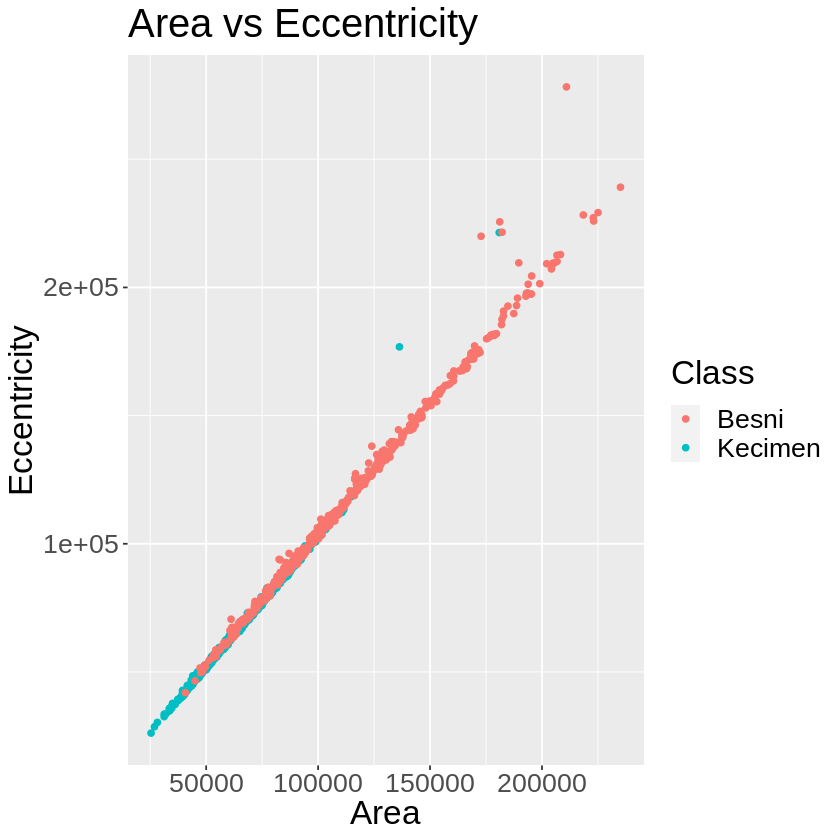

In [11]:
raisin_data |>
   ggplot(aes(x = Area, y = Eccentricity,color = Class)) +
     geom_point() +
     labs(x = "Area", y = "Eccentricity") +
  ggtitle("Area vs Eccentricity")+
    theme(text = element_text(size = 20))

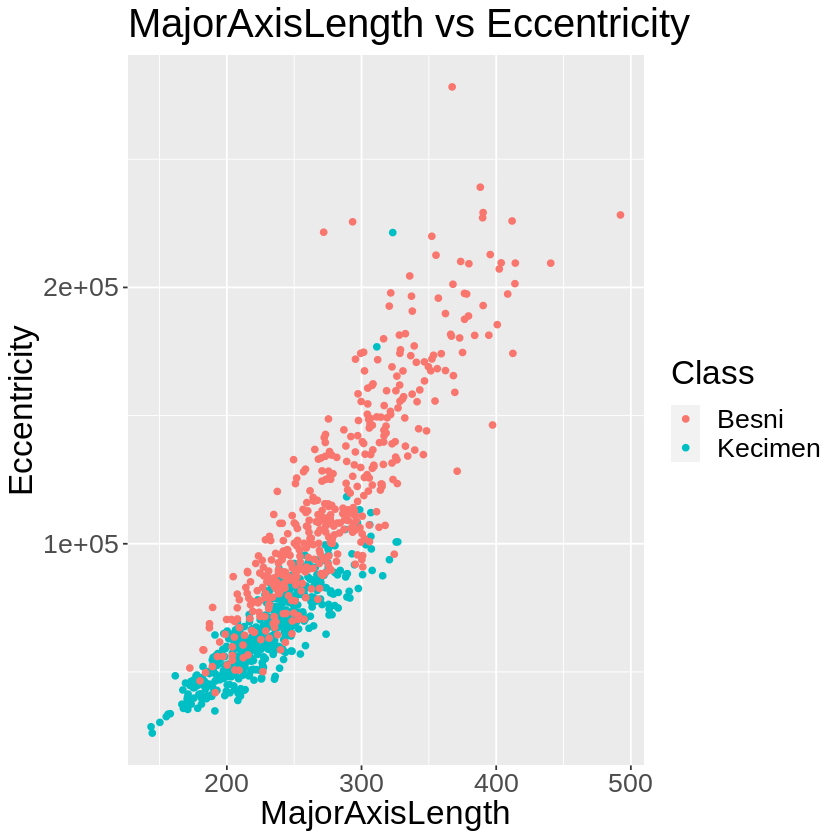

In [8]:
find_K <-raisin_data |>
   ggplot(aes(x = MajorAxisLength, y = Eccentricity,color = Class)) +
     geom_point() +
     labs(x = "MajorAxisLength", y = "Eccentricity") +
 ggtitle("MajorAxisLength vs Eccentricity")+
    theme(text = element_text(size = 20))
find_K

In [9]:
raisin_recipe <- recipe(Class ~ MajorAxisLength + Eccentricity, data = raisin_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

cancer_vfold <- vfold_cv(raisin_train, v = 5, strata = Class)

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(raisin_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = cancer_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7832529,5,0.013459725,Preprocessor1_Model01
6,accuracy,binary,0.8307726,5,0.008998587,Preprocessor1_Model02
11,accuracy,binary,0.8573968,5,0.012274304,Preprocessor1_Model03
16,accuracy,binary,0.8485075,5,0.011851516,Preprocessor1_Model04
21,accuracy,binary,0.8500658,5,0.009783505,Preprocessor1_Model05
26,accuracy,binary,0.8485953,5,0.008927948,Preprocessor1_Model06
31,accuracy,binary,0.8500878,5,0.008830174,Preprocessor1_Model07
36,accuracy,binary,0.8501097,5,0.008101440,Preprocessor1_Model08
41,accuracy,binary,0.8471466,5,0.008136746,Preprocessor1_Model09


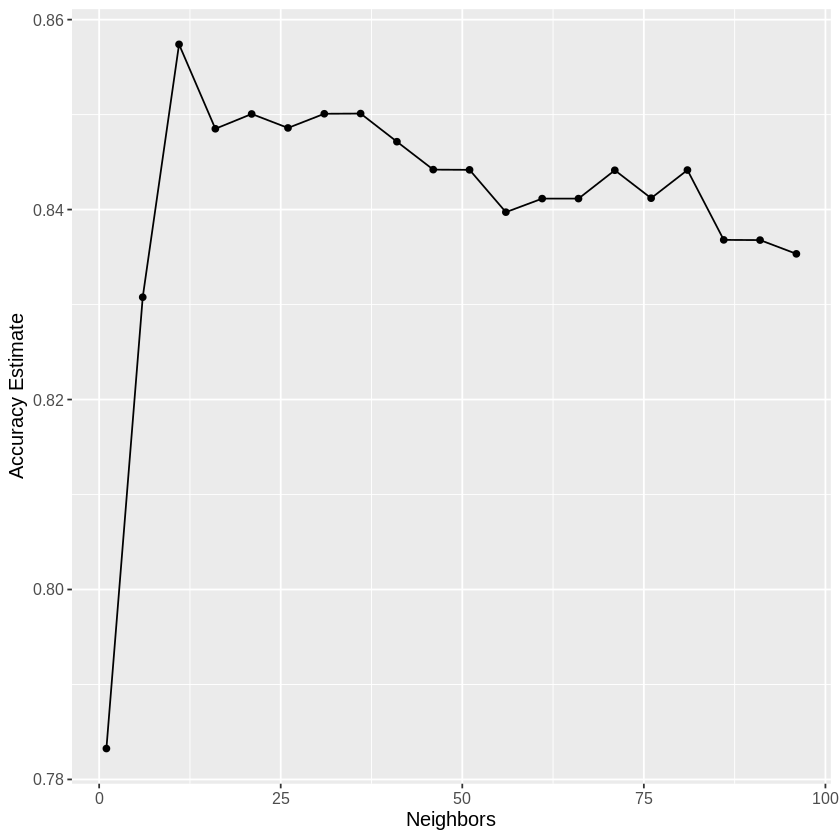

In [10]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

## Expected outcomes and significance